In [2]:
import ldc.waveform.fastGB as FB
from ldc.lisa import orbits
from astropy import units as un
import numpy as np
#from memory_profiler import profile
import fastGB as FB_MLDC
import matplotlib.pyplot as plt
import math

In [3]:
#SourceParameters

#def chi_f(alpha_f,m):
#        return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def func_h0(M,alpha,chi,chi_f):
    return(8e-28/10)*(M)*(alpha/0.1)**7*((chi-chi_f)/0.1)

def func_freq(M,alpha):
    return (645)*(10/M)*(alpha/0.1)

def func_fdot(M,alpha,chi):
    return 3e-14*(10**2/M)**2*(alpha/0.1)**19*chi**2

def param(M,alpha,chi,chi_f):
    tab=[]
    h0=func_h0(M,alpha,chi,chi_f)
    
    long=np.random.uniform(-np.pi,np.pi)
    lat=np.random.uniform(-np.pi/2,np.pi/2)
    
    f=func_freq(M,alpha)
    fdot=func_fdot(M,alpha,chi)
    
    inc=np.arccos(np.random.uniform(-1,1))
    initialPhase=np.random.uniform(0,2*np.pi)
    pol=np.random.uniform(0,2*np.pi)
    
    tab=(h0,long,lat,f,fdot,inc,initialPhase,pol)
    return tab


tab_Param=param(M=10**6,alpha=0.12,chi=0.5,chi_f=0.45)
print(tab_Param)

(1.4332723199999993e-22, -1.921721865391373, 0.969416433283409, 0.00774, 2.3960999952796703e-21, 0.48948200134160036, 3.6411920364355286, 1.3569088730259689)


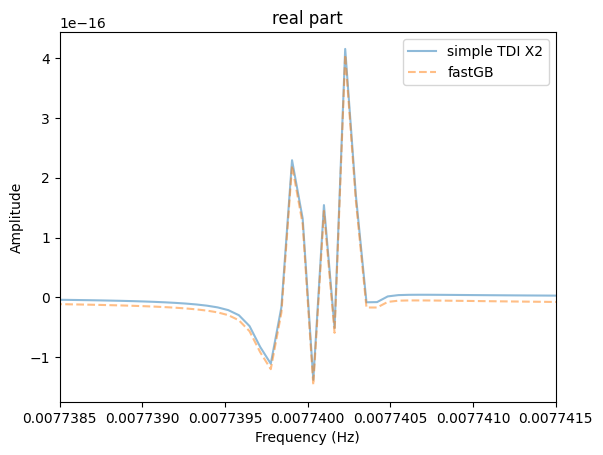

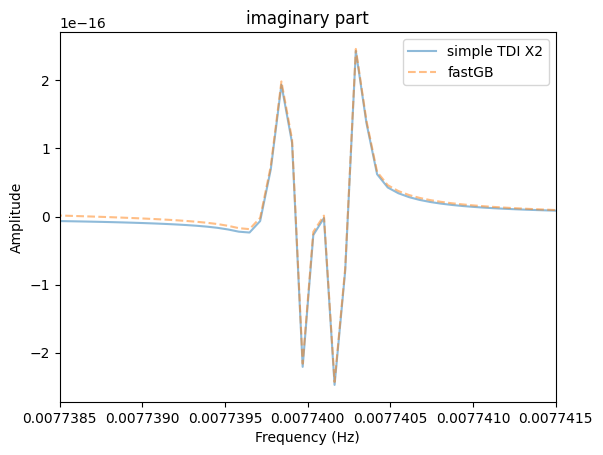

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from ldc.lisa.orbits import Orbits
from ldc.waveform.waveform import HpHc
from ldc.lisa.projection import ProjectedStrain
import ldc.io.yml as ymlio
import os
import h5py
import ldc.waveform.fastGB as FB
from ldc.common.series import TimeSeries
from ldc.common import constants

config = {"dt":15.0, "initial_position": 0, "initial_rotation": 0, 
          "nominal_arm_length": 2500000000, "orbit_type": 'analytic', 
          "t_max": 60*60*24*30*6, "t_min": 0, "travel_time_order": 1}


cat = np.array([tab_Param],
               dtype=[('Amplitude', '<f8'),
                      ('EclipticLatitude', '<f8'),
                      ('EclipticLongitude', '<f8'),
                      ('Frequency', '<f8'), ('FrequencyDerivative', '<f8'),
                      ('Inclination', '<f8'), ('InitialPhase', '<f8'),
                      ('Polarization', '<f8')])

GB = HpHc.type("GB", "GB", "TD_fdot")
GB.set_param(cat)
GWs = GB.split()

globals().update(config)
trange = np.arange(t_min, t_max, dt)
orbits = Orbits.type(config)
P = ProjectedStrain(orbits)
yArm = P.arm_response(t_min, t_max, dt, GWs, tt_order=travel_time_order)

simple_tdi_X = P.compute_tdi_x(trange, tdi2=False)
simple_tdi_X = TimeSeries(simple_tdi_X,dt=dt,t0=t_min)
simple_tdi_X = simple_tdi_X.ts.fft()

simple_tdi2_X = P.compute_tdi_x(trange, tdi2=True)
simple_tdi2_X = TimeSeries(simple_tdi2_X, dt=dt,t0=t_min)
simple_tdi2_X = simple_tdi2_X.ts.fft()

GB = FB.FastGB(delta_t=dt, T=t_max)
pGB = dict(zip(cat.dtype.names, cat[0]))
X, Y, Z = GB.get_fd_tdixyz(template=pGB)
X2, Y2, Z2 = GB.get_fd_tdixyz(template=pGB, tdi2=True)

plt.figure()
plt.title("real part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.real, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.real, alpha=0.5, label="fastGB",linestyle='dashed')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlim([0.0077385,0.0077415])
plt.legend()
plt.figure()
plt.title("imaginary part")
plt.plot(simple_tdi2_X.f, simple_tdi2_X.imag, alpha=0.5, label="simple TDI X2")
plt.plot(X2.f, X2.imag, alpha=0.5, label="fastGB",linestyle='dashed')
plt.axis([pGB["Frequency"]-1e-6, pGB["Frequency"]+3e-6, None, None])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.xlim([0.0077385,0.0077415])
plt.legend()


In [5]:
X2_t,Y2_t,Z2_t=GB.get_td_tdixyz(template=pGB,oversample=4,tdi2=True)
print(dt)

15.0


In [6]:
print(dt)
print(t_max/dt)
print(len(X2_t))

15.0
1036800.0
1036799


1036799


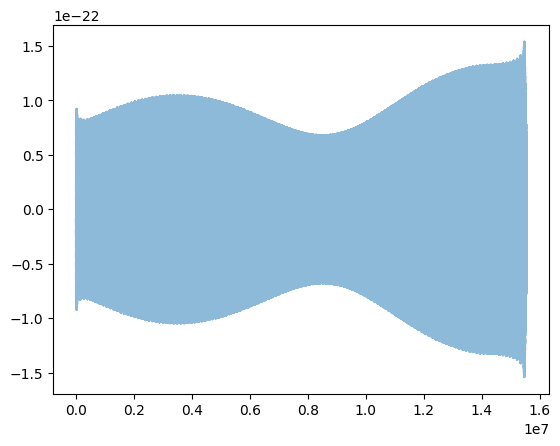

In [7]:
plt.plot(X2_t.t, X2_t, alpha=0.5, label="fastGB",linestyle='dashed')
#plt.axis(1/[pGB["Frequency"]-1e-6, 1/pGB["Frequency"]+3e-6, None, None])
print(len(X2_t))

15.20834800187886
1036799


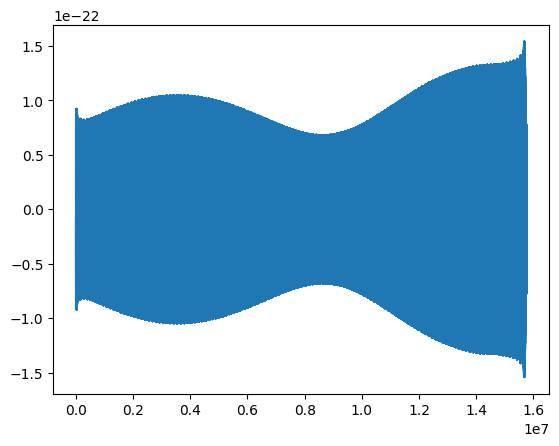

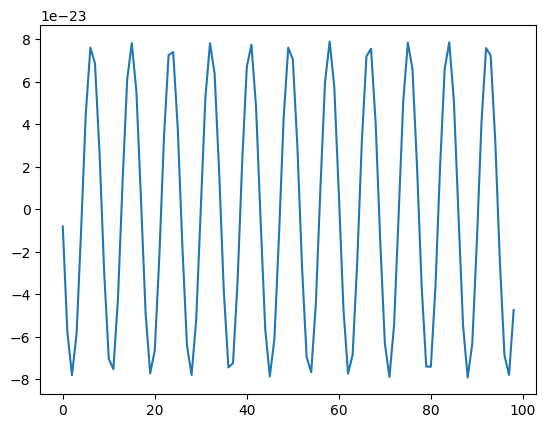

In [8]:
N=len(X2_t)
Tobs = 365*24*60*60*0.5
T=Tobs
dt=T/N

t= np.arange(0, Tobs,T/N)
plt.plot(t,X2_t)
print(dt)
print(len(t))
plt.figure()
plt.plot(X2_t[:-1036700])

In [9]:
import ldc
from ldc.lisa.noise import get_noise_model
from ldc.lisa.noise import NumericNoise
AddLDC = True

import backgroundsmaster
from backgroundsmaster.backgrounds.utils import generate_noise
generate_noise

f_sampling=1/dt
#get_noise_model("SciRDv1",f).psd(option='X',tdi2=True)
N=len(X2_t)

c=299792458.0
L_m = 2.5e9
L = L_m/c
#omegaL = 2*np.pi*f*L
f1=0.4e-3
def Sn_X2(f):
    S_I=5.76e-48*(1+(f1/f)**2)
    S_II=3.6e-41
    return (4*np.pi*f*L)**2*(np.sin(np.pi*f*L))**2*(2*np.sin(2*np.pi*f*L))**2*((S_I/(2*np.pi*f)**4)+S_II)

tab_noise_t=generate_noise(psd_func=Sn_X2, n_data=N, fs=f_sampling)

In [35]:
c=299792458.0
L_m = 2.5e9
L = L_m/c

## Noise level in the Science Requirement Document
sqSnoise_SciRD = [3e-15,15e-12]

## Noise level in the Science Requirement Document
sqSnoise_MRD = [2.4e-15,10e-12]

def PSD_Noise_components(fr, sqSnoise):
    [sqSacc_level, sqSoms_level] = sqSnoise
    # sqSacc_level: Amplitude level of acceleration noise [3e-15]
    # sqSoms_level: Amplitude level of OMS noise [15e-12]
    
    
    ### Acceleration noise
    Sa_a = sqSacc_level**2 *(1.0 +(0.4e-3/fr)**2)*(1.0+(fr/8e-3)**4)
    Sa_d = Sa_a*(2.*np.pi*fr)**(-4.)
    Sa_nu = Sa_d*(2.0*np.pi*fr/c)**2

    ### Optical Metrology System
    Soms_d = sqSoms_level**2 * (1. + (2.e-3/fr)**4)
    Soms_nu = Soms_d*(2.0*np.pi*fr/c)**2
    
    return [Sa_nu, Soms_nu]

def PSD_Noise_X20(f):
    [Sa_nu,Soms_nu] = [3e-15,15e-12]
    phiL = 2*np.pi*f*L
    return 64 * (np.sin(phiL))**2 * ( np.sin(2*phiL))**2 * (Soms_nu + Sa_nu*(3+np.cos(2*phiL)) )


In [36]:
noise_t=generate_noise(psd_func=PSD_Noise_X20, n_data=N, fs=f_sampling)

NameError: name 'generate_noise' is not defined

[-2.83434253e-21  1.24601657e-21  8.23772869e-22 ...  5.19600870e-22
  4.74055155e-22 -3.59510763e-22]


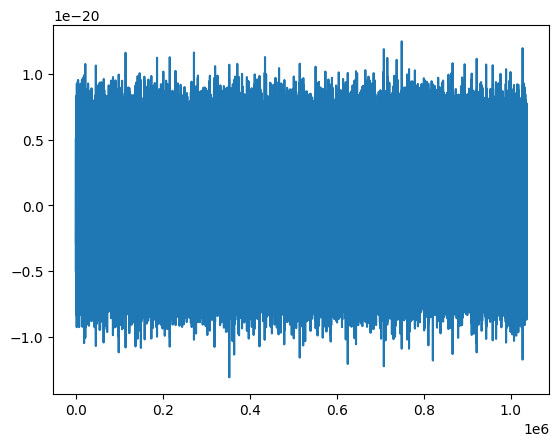

In [10]:
print(tab_noise_t)
plt.plot(tab_noise_t)

518400


(5e-05, 0.03)

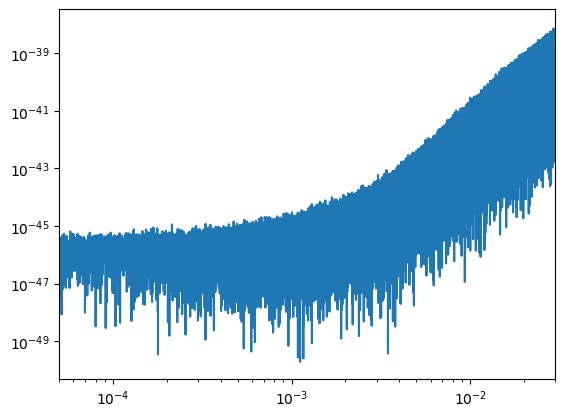

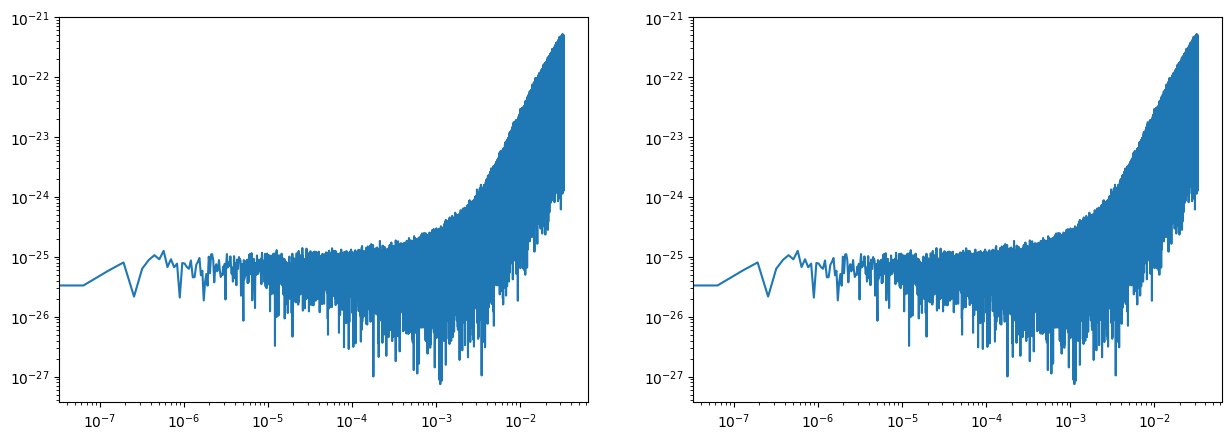

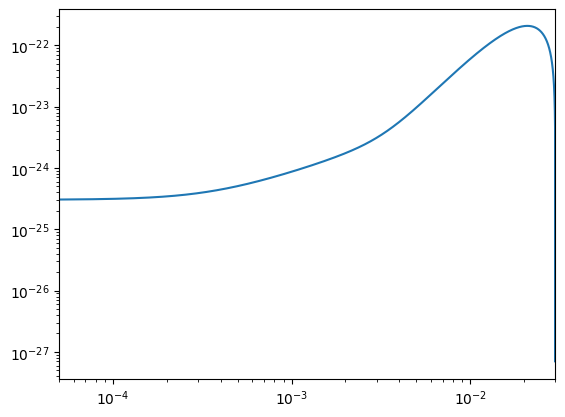

In [11]:
def Pd_num(x,dt):
    #window=np.blackman(len(x))
    window=1
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))**2

def FT_norm(x,dt):
    #window=np.blackman(len(x))
    window=1
    #N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))

f= np.fft.rfftfreq(int(N),d=dt)
plt.figure()
plt.loglog(f,Pd_num(tab_noise_t,dt))
plt.xlim([5e-5,3e-2])
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.loglog(f,FT_norm(tab_noise_t,dt))
plt.subplot(1,2,2)
plt.loglog(f,np.sqrt(dt*(2/N))*np.sqrt(Pd_num(tab_noise_t,dt)))
print(len(FT_norm(tab_noise_t,dt)))

factor=np.sqrt(dt*(2/N))
plt.figure()
PSD_sciRD_X2usb=get_noise_model("SciRDv1",f[1:]).psd(option='X',tdi2=True)
plt.loglog(f[1:],factor*np.sqrt(PSD_sciRD_X2usb))
plt.xlim([5e-5,3e-2])

15.20834800187886


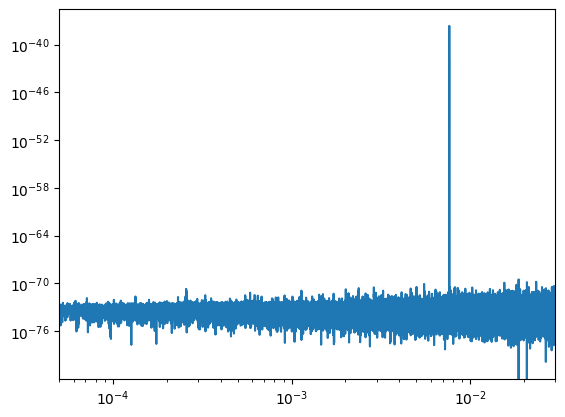

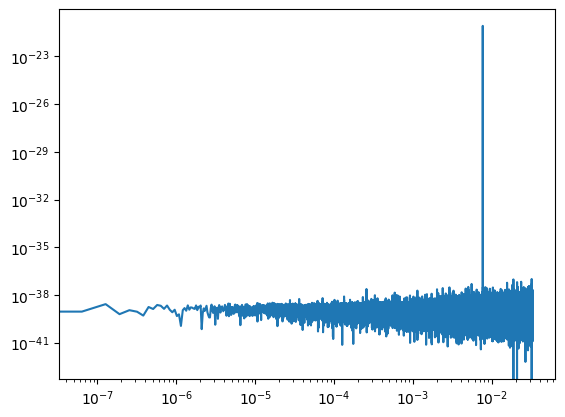

In [12]:
N=len(X2_t)
print(dt)
def Pd_num(x,dt):
    #window=np.blackman(len(x))
    window=1
    N_w=np.sum(window**2)
    N_w=len(x)
    return dt*(2/N_w)*(np.abs(np.fft.rfft(window*x)))**2


f= np.fft.rfftfreq(int(N),d=dt)
plt.loglog(f,Pd_num(X2_t,dt))
plt.xlim([5e-5,3e-2])
plt.figure()
plt.loglog(f,FT_norm(X2_t,dt))

Text(0.5, 0, 'Frequency (Hz)')

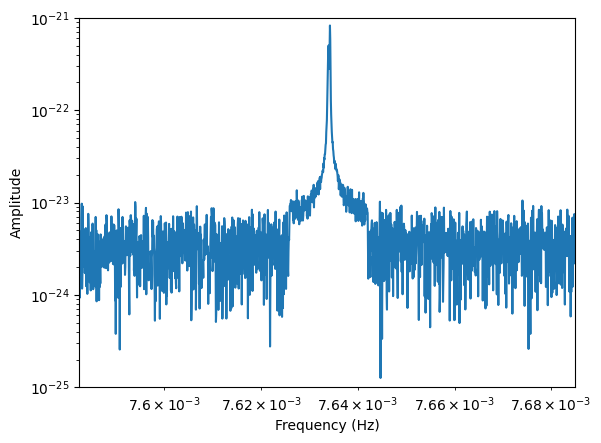

In [13]:
h=FT_norm(X2_t,dt)
n=FT_norm(tab_noise_t,dt)
d=h+n
plt.loglog(f,d)
plt.ylim([1*10**(-25),(10**(-21))])
plt.xlim([pGB["Frequency"]-1e-3, pGB["Frequency"]+0.75e-3])
plt.xlim(7.5825e-3, 7.685e-3)
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')

In [14]:
print(cat)

[(1.43327232e-22, -1.92172187, 0.96941643, 0.00774, 2.3961e-21, 0.489482, 3.64119204, 1.35690887)]


119561
121177
Size of new window : 1616


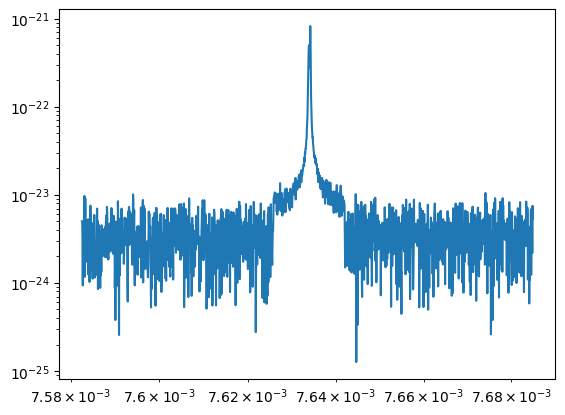

In [15]:
pos_1=[]
pos_2=[]
def position(freq,tf):
    for f,i in zip (freq,range(len(tf))):
        if f>=7.5825e-3:
            pos_1.append(i)
            p1=pos_1[0]
        if f<=7.685e-3:
            pos_2.append(i)
            p2=pos_2[-1]
    return p1,p2

p1,p2=position(f,n)
print(p1)
print(p2)
print("Size of new window :",p2-p1)

f_n=f[p1:p2]
d_n=d[p1:p2]

plt.loglog(f_n,d_n)

In [ ]:
def loglikelihood(d,h,Sn):
    return -np.sum(np.abs(d_n-h_n)**2/Sn_n)

In [16]:
def par2dic(par):
    """
    Transforms parameter array into a dictionnary.

    Parameters
    ----------
    par : ndarray
        waveform parameters:
        Amplitude
        Ecliptic latitude
        Ecliptic longitude
        Frequency
        Frequency derivative
        Inclination
        Initial phase
        Polarization

    """
    pgb = dict({'Amplitude': par[0],# "strain"
              'EclipticLatitude': par[1], # "radian"
              'EclipticLongitude': par[2],# "radian"
              'Frequency': par[3], #"Hz"
              'FrequencyDerivative': par[4],# "Hz^2"
              'Inclination': par[5],# "radian"
              'InitialPhase': par[6], #"radian"
              'Polarization': par[7]}) #"radian"

    return pgb


def waveform2sample(par):
    """
    Tramsform waveform parameters into a format suitable for sampling

    Parameters
    ----------
    par : ndarray
        waveform parameters
        # Amplitude
        # Ecliptic latitude
        # Ecliptic longitude
        # Frequency
        # Frequency derivative
        # Inclination
        # Initial phase
        # Polarization

    Returns
    -------
    psample : ndarray
        log10(amplitude), frequency in mHz, log10(frequency derivative)
        sin(Latitude), Longitude, cos(inclination), polarization, Initial phase

    """

    Amp, bet, lam, f0, fdot, iota, phi0, psi = par
    sin_b = np.sin(bet)
    cos_i = np.cos(iota)
    l_Amp = np.log10(Amp)
    l_fdot = np.log10(fdot)

    p_sample = np.array([l_Amp, f0*1.e3, l_fdot, sin_b, lam, cos_i, psi, phi0])

    return p_sample


def waveform_from_samplepar(pars, freqs=None):
    """

    Compute the waveform in X, Y, Z from sampling parameters


    Parameters
    ----------
    pars : ndarray
        log10(amplitude),
        frequency in mHz,
        log10(frequency derivatite)
        sin(Latitude),
        Longitude,
        cos(inclination),
        polarization,
        Initial phase


    Returns
    -------
    Xf, Yf, Zf : FrequencyArrays
        Waveform in the frequency domain in TDI X, Y, Z [second]

    """
    pp = pars[:]
    l_Amp = pp[0]
    mf0 = pp[1]
    l_fdot = pp[2]
    sin_bet = pp[3]
    lam = pp[4]
    cos_iota = pp[5]
    psi = pp[6]
    phi0 = pp[7]

    # Transform sampling parameters into waveform parameters
    iota = np.arccos(cos_iota)
    beta = np.arcsin(sin_bet)
    Amp = 10.0**l_Amp
    f0 = mf0 *1.e-3
    fdot = 10.0**l_fdot

    pgb = dict({'Amplitude': Amp,# "strain"
              'EclipticLatitude': beta, # "radian"
              'EclipticLongitude': lam,# "radian"
              'Frequency': f0, #"Hz"
              'FrequencyDerivative': fdot,# "Hz^2"
              'Inclination': iota,# "radian"
              'InitialPhase': phi0, #"radian"
              'Polarization': psi}) #"radian"

    Xf, Yf, Zf = GB.get_fd_tdixyz(
        template=pgb, oversample=4, tdi2=True, freqs=freqs)

    return Xf, Yf, Zf


def loglike(pars, dataf, id):
    """
    Log-likelihood

    Parameters
    ----------
    pars : ndarray
        array of sampling parameters :
        log10(amplitude)
        frequency (mHz)
        log10(frequencyDerivative)
        sinus(beta) : sinus of latitude
        lambda : longitude
        cos(i) : cosinus of inclination
        psi : polarization angle [rad]
        phi0 : initial phase [rad]
    dataf : ndarray
        full data in the frequency domain
    id : ndarray
        indices of the frequency bins to consider

    Returns
    -------
    loglik : float
        likelihood value

    """

    #freqs = dataf.f[id]
    freqs=f_n
    Xf, Yf, Zf = waveform_from_samplepar(pars, freqs=freqs)

    df = 1/GB.T
    # # Index of the first data frequency
    # ib = int(freqs[0] / df)
    # # Index of the last data frequency
    # ie = int(freqs[-1] / df)

    f0 = pars[1]*1e-3
    #Sn = noise_model.psd(freq=f0, option='X', tdi2=True)
    Sn=get_noise_model("SciRDv1",f0).psd(option='X',tdi2=True)

    # Xf = Xf/df
    #SNR2 = np.sum( np.real(dataf[id] * np.conjugate(Xf)) )
    SNR2 = np.sum( np.real(d_n * np.conjugate(Xf)) )
    hh = np.sum(np.absolute(Xf)**2)
    loglik = 4.0*df*( SNR2 - 0.5 * hh )/Sn

    return float(loglik)

In [17]:
id=np.arange(p1,p2)
print(len(id))

1616


In [18]:
print(len(cat))
print(cat[0])
print(type(cat[0]))
cat_a=np.array(cat[0])
print(type(cat_a))
#print(len(cat_a))
param_array=np.array([1.43327232e-22, 2.12578338, 0.25878119, 0.00774, 2.3961e-21, 1.81178354, 0.62268665, 5.94923749])
print(len(param_array))

1
(1.43327232e-22, -1.92172187, 0.96941643, 0.00774, 2.3961e-21, 0.489482, 3.64119204, 1.35690887)
<class 'numpy.void'>
<class 'numpy.ndarray'>
8


In [19]:
#t1_param=par2dic(param_array)
t2_param=waveform2sample(param_array)
print(t2_param)

[-21.84367129   7.74       -20.62049506   0.84990726   0.25878119
  -0.23866143   5.94923749   0.62268665]


In [20]:
p_sample_true = waveform2sample(param_array)

In [21]:
# Lower bounds
#p0[0]=param_array[0]
#p0[1]=param_array[3]
a = np.array([t2_param[0] - 1, t2_param[1] - 1e-3, -24.0, -1.0, -np.pi, -1.0, 0.0, 0.0])
# Upper bounds
b = np.array([t2_param[0] + 1, t2_param[1] + 1e-3, -18.0, 1.0, np.pi, 1.0, 2.0*np.pi, 2.0*np.pi])

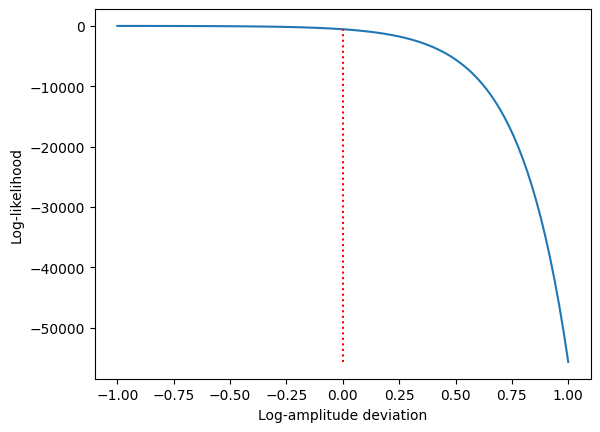

In [22]:
import copy
from ldc.lisa import noise

nvalues = 100
prange = np.linspace(a[0], b[0], nvalues)
dps = prange - p_sample_true[0]
l_vect = np.zeros(nvalues)
s_vect = np.zeros(nvalues)
ps = copy.deepcopy(p_sample_true)
# plt.figure(0)
for i in range(nvalues):
    ps[0] = prange[i]
    l_vect[i] = loglike(ps, n, id)
# Likelihood at true parameter value
l_true = loglike(p_sample_true, n, id)

plt.figure(0)
plt.plot(dps, l_vect)
plt.xlabel("Log-amplitude deviation")
plt.ylabel("Log-likelihood")
plt.vlines(x=0.0, ymin=np.min(l_vect), ymax=l_true,
           label='True value', color='red', linestyle='dotted')
plt.show()

In [55]:
#sampler 
#priors
from scipy.special import gamma

Phi_s=10**(-3)
logMass_s=8.4
M_star=10**logMass_s
a=-1.19
beta2=0.5116394637708428
alpha_moy=0.12
alpha=alpha_moy
chi=0.5

def Dist_BH(M,d):
    return (1/(d+1))**(beta2)*Phi_s*(M/M_star)**(1+a)*np.exp(1-(M/M_star))

def P_M(M):
    return Phi_s*(M/(M_star))**(1+a)*np.exp(1-(M/M_star))

#Amplitudeh_0
m=1
def chi_f(alpha_f):
    return (4*alpha_f*m)/(4*alpha_f*m+m)
    
def dist_z(z):
    return Phi_s*(M_star/z)**(2-beta2)*np.exp(1)*gamma(a-beta2+3)


C1=(8e-28/10)*(alpha/0.1)**7*(10**6)*((chi-0.45)/0.1)
def P_h0(x):
    x=10**x
    return ((1/(C1))*dist_z(x/C1))
def P_h0bis(x):
    return (1/C1)*Phi_s*(M_star/(x/C1))**(2-beta2)*np.exp(1)*gamma(a-beta2+3)

#frequency
C2=(645*10*alpha_moy)/0.1
def P_f0(x):
    x=x*1e-3
    return (C2/x**2)*P_M((C2/x))
    


#frequency derivative

C3=3e-14*10**2*(alpha/0.1)**19*chi**2
def P_f0dot(x):
    x=10**x
    return (np.sqrt(C3)/2)*(1/x**(3/2))*P_M(np.sqrt(C3/x))

#Position
def P_lat(sinbeta):
       return 1/np.pi
    
def P_long(lamb):
    return 1/(2*np.pi)

def P_cos_inc(x):
    return 1/2


def P_Pol(x):
    return 1/(2*np.pi)

def P_Phase(x):
    return 1/(2*np.pi)

    

#Theta=(h0,f,fdot,(beta,lamb))

In [60]:
print ((1/(C3))*(dist_z(10**(-22)/C3)))
print(P_h0(-21))
print(P_f0(7))
print(Dist_Mass1(10**7))

[-1.05702292e+11  8.23768601e+35  2.47687035e+09 -3.65217219e+32
 -9.24200428e+31 -3.65217219e+32  1.86859542e+32  1.86859542e+32]
[-3.43339576e+09  2.67574485e+34  8.04530918e+07 -1.18628956e+31
 -3.00196503e+30 -1.18628956e+31  6.06952554e+30  6.06952554e+30]
[1.03545508e+45 8.94205367e-28 5.49356937e+47 3.49656647e-07
 3.89044069e-02 3.49656647e-07 1.53916333e-09 1.53916333e-09]
[9.95737144e+27 1.52196585e-15 4.14004353e+29 2.61219087e-03
 2.60156465e+00 2.61219087e-03 1.03993192e-04 1.03993192e-04]


In [73]:
def logprior_set(theta,a,b):
    logh0,f,logfdot,sinbeta,lamb,cos_i,pol,ph=theta
    if (np.all(a <= theta) and np.all(b >= theta)) and (((lamb >= -np.pi)&(lamb<=np.pi)) and ((sinbeta >= -1) & (sinbeta >= 1))
    and ((cos_i >= -1)&(cos_i<=1)) and ((pol >= -np.pi)&(pol <=np.pi)) and ((ph >= -np.pi)&(ph <=np.pi))):
        
        p=np.log(P_h0(logh0))+np.log(P_f0(f))+np.log(P_f0dot(logfdot))+np.log(P_lat(sinbeta))+np.log(P_long(lamb))
        +np.log(P_cos_inc(cos_i))+np.log(P_Pol(pol))+np.log(P_Phase(ph))
    else :
        p=-np.inf
    return p

In [69]:
# Lower bounds
a = np.array([t2_param[0] - 1, t2_param[1] - 1e-3, -24.0, -1.0, -np.pi, -1.0, 0.0, 0.0])
# Upper bounds
b = np.array([t2_param[0] + 1, t2_param[1] + 1e-3, -18.0, 1.0, np.pi, 1.0, 2.0*np.pi, 2.0*np.pi])

In [50]:
print(param_array)
print(t2_param)

[1.43327232e-22 2.12578338e+00 2.58781190e-01 7.74000000e-03
 2.39610000e-21 1.81178354e+00 6.22686650e-01 5.94923749e+00]
[-21.84367129   7.74       -20.62049506   0.84990726   0.25878119
  -0.23866143   5.94923749   0.62268665]


In [74]:
import corner
import ptemcee
from PTMCMCSampler import PTMCMCSampler

ndim = len(t2_param)
nwalkers = 8 * ndim
ntemps = 20
nit = 4000
thin = 1
nsave = 1000
nverbose = 10

# Instantiate the sampler
sampler = ptemcee.Sampler(nwalkers, ndim, loglike,
                              logprior_set, ntemps=int(ntemps),
                              loglargs=[d_n,id],
                              logpargs=[a,b],
                              pool=None)
# Intialize the parameter state
pos = np.random.uniform(low=a,high=b,size=(ntemps, nwalkers, ndim))
#print (pos[0])

In [75]:
# Run the sampler (long!)
result = sampler.run_mcmc(p0=pos, iterations=nit, thin=thin)
chaindata = sampler.chain[:]

ValueError: Attempting to start with samples outside posterior support.